# __Проект 'ProcrastinatePro+'__  


Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

__Задачи исследовательского проекта:__  
* Откуда приходят пользователи и какими устройствами они пользуются;  
* Сколько стоит привлечение пользователей из различных рекламных каналов;
* Сколько денег приносит каждый клиент;
* Когда расходы на привлечение клиента окупаются;
* Какие факторы мешают привлечению клиентов;

## Исходные данные

In [1]:
# Подключаем библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime, timedelta

In [2]:
# Подключаем файлы csv для дальнейшей работы
# локальный
try:
    visits = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    costs = pd.read_csv('costs_info_short.csv')
except:
# Яндекс
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')

# Переводим даты в тип datetime
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])

orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [3]:
# Переведем названия в привычный вид для удобства дальнейшей работы
visits.columns = ['user_id','region','device','channel','session_start','session_end']
orders.columns = ['user_id','event_dt','revenue']
costs.columns = ['dt','channel','costs']

In [4]:
visits.head()
orders.head()
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


## Предобработка данных

### Проверка типов данных и пропусков

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропусков не обнаружено

### Проверка дубликатов

#### Явные дубликаты

In [8]:
visits.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
costs.duplicated().sum()

0

Явных дубликатов не обнаружено

#### Неявные дубликаты

In [11]:
# Region
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [12]:
# Device
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

Неявных дубликатов также не обнаружено

<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.2</b>
    
  ✔️ Данные получены и подготовлены к анализу! Хорошо, что заметил неверный формат даты и поменял.
</div>

## LTV, ROI, удержание и конверсия

### Создание профиля пользователя

In [13]:
def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = pd.to_datetime(profiles['first_ts']).dt.month

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    # for event in event_names:
    #     if event in events['event_name'].unique():
    #         # проверяем, встречается ли каждый пользователь
    #         # среди тех, кто совершил событие event
    #         profiles[event] = profiles['user_id'].isin(
    #             events.query('event_name == @event')['user_id'].unique()
    #         )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

### Подсчет Retention Rate

In [14]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],  # параметр для группировки таблицы удержания
    ignore_horizon=False,
):

    # --- получаем сырые данные и таблицу удержания ---

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)

    # display(result_grouped)
    
    result_grouped = result_grouped.div(
        result_grouped['cohort_size'], axis=0
    )
    
    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]
    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # --- создаём таблицу динамики удержания ---

    # добавляем даты привлечения в параметр dimensions
    dimensions = ['dt'] + dimensions

    # рассчитываем удержание
    result_in_time = result_raw.pivot_table(
        index=dimensions,
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_in_time = cohort_sizes.merge(
        result_in_time, on=dimensions, how='left'
    ).fillna(0)
    result_in_time = result_in_time.div(
        result_in_time['cohort_size'], axis=0
    )

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_in_time = result_in_time[
        ['cohort_size'] + list(range(horizon_days))
    ]
    # восстанавливаем столбец с размерами когорт
    result_in_time['cohort_size'] = cohort_sizes

    # возвращаем сырые данные, таблицу удержания и таблицу динамики удержания
    return result_raw, result_grouped, result_in_time

### Конверсия

In [15]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Подсчет LTV

In [16]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Визуализация

#### Функция сглаживания данных

In [17]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Построения графиков Retention Rate

In [18]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()



#### Построение графиков Conversion

In [19]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()



#### Построение графиков LTV и ROI

In [20]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


## Исследовательский анализ

In [21]:
# Создадим профили пользователей
profiles = get_profiles(visits, orders, costs)

# Определим максимальную и минимальную даты привлечения
min_dt = profiles.sort_values(by='dt')['dt'].values[1]
max_dt = profiles.sort_values(by='dt')['dt'].values[-1]
print('Минимальная дата привлечения:',min_dt)
print('Максимальная дата привлечения:',max_dt)

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


**Вывод**   
Пользователи, на которых основывается данное исследование, были привлечены в теплое время года: с начала мая по конец октября

Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [22]:
payer = profiles.groupby('region').agg({'payer':'sum','user_id':'nunique'}).sort_values(by='user_id',ascending=False)
payer['part'] = round(payer['payer']/payer['user_id'],2)
payer

,payer,user_id,part
region,,,
United States,6902,100002,0.07
UK,700,17575,0.04
France,663,17450,0.04
Germany,616,14981,0.04


**Вывод**   
Больше всего пользователей пришло из США. Также пользователи из данной страны имеют более высокий показатель конверсии в платящих

In [23]:
# Создаем таблицу с общим количеством и числом платящих пользователей по девайсам
device = profiles.groupby('device').agg({'payer':'sum','user_id':'nunique'}).sort_values(by='user_id',ascending=False)
device['part'] = round(device['payer']/device['user_id'],3)
device

,payer,user_id,part
device,,,
iPhone,3382,54479,0.062
Android,2050,35032,0.059
PC,1537,30455,0.050
Mac,1912,30042,0.064


**Вывод**   
Большая часть привлеченных пользователей является владельцами iPhone.  
Самые высокие показатели конверсии показывают владельцы Mac

In [24]:
# Создаем таблицу с общим количеством и числом платящих пользователей по каналам привлечения
channel = profiles.groupby('channel').agg({'payer':'sum','user_id':'nunique'}).sort_values(by='user_id',ascending=False)
channel['part'] = round(channel['payer']/channel['user_id'],3)
channel

,payer,user_id,part
channel,,,
organic,1160,56439,0.021
FaceBoom,3557,29144,0.122
TipTop,1878,19561,0.096
OppleCreativeMedia,233,8605,0.027
LeapBob,262,8553,0.031
WahooNetBanner,453,8553,0.053
RocketSuperAds,352,4448,0.079
MediaTornado,156,4364,0.036
YRabbit,165,4312,0.038


**Вывод**   
Большая часть привлеченных пользователей пришли самостоятельно, на втором месте - FaceBoom  
Самые высокие показатели конверсии показывают люди, привлеченные с помощью FaceBoom

### Вывод по главе Исследовательский анализ
* Рекламная компания проводилась в теплое время года
* Большая часть новых пользователей из США. Там же и самая высокая конверсия
* Большинство из привлеченных - владельцы айфон, однако самая высокая конверсия у владельцев Mac
* Большинство людей пришло самостоятельно (органический прирост), но самая высокая конверсия была достигнута с помощью FaceBoom

## Маркетинг

#### Общие затраты на маркетинг

In [25]:
sum_m = costs['costs'].sum()
print('Общая сумма расходов на маркетинг = ', round(sum_m,2))

Общая сумма расходов на маркетинг =  105497.3


#### Траты по источникам

In [26]:
costs_gr = costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs',ascending=False)
costs_gr

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


В TipTop и FaceBoom была вложена большая часть рекламного бюджета 

#### Визуализация динамики трат по источникам

Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику.   
Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.

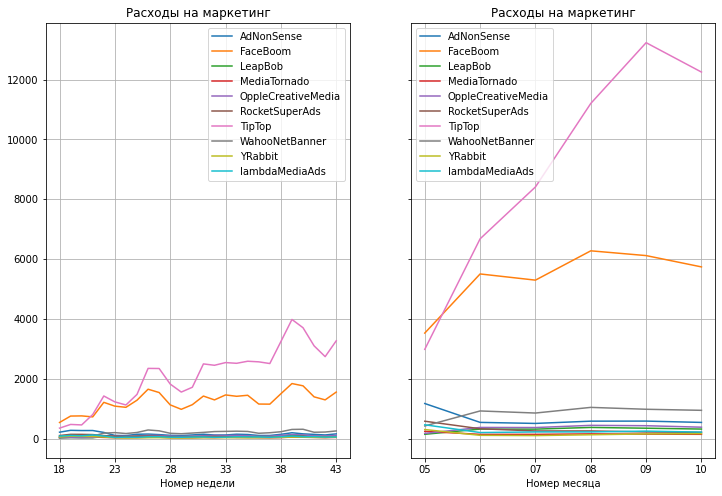

In [27]:
costs_w = costs.copy(deep='True')
costs_m = costs.copy(deep='True')

costs_w['dt'] = pd.to_datetime(costs_w['dt'])
costs_m['dt'] = pd.to_datetime(costs_m['dt'])
# Переводим дату в номер недели или месяца
costs_w['dt'] = costs_w['dt'].dt.strftime("%V")
costs_week = costs_w.pivot_table(
        index=['dt'], columns='channel', values='costs', aggfunc='sum'
)

costs_m['dt'] = costs_m['dt'].dt.strftime("%m")
costs_month = costs_m.pivot_table(
        index=['dt'], columns='channel', values='costs', aggfunc='sum'
)

plt.figure(figsize=(12, 8))

# Визуализация по неделям
ax1 = plt.subplot(1, 2, 1)
costs_week.plot(grid=True,ax =ax1)
plt.legend()
plt.xlabel('Номер недели')
plt.title('Расходы на маркетинг')

# Визуализация по месяцам
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
costs_month.plot(grid=True,ax=ax2)
plt.legend()
plt.xlabel('Номер месяца')
plt.title('Расходы на маркетинг')

plt.show()

По вышеприведенным графикам можно заметить, что с каждым месяцем на TipTop и FaceBoom тратили намного больше,   
чем на все остальные источники рекламы

#### САС по источникам

CAC, или Customer Acquisition Cost — стоимость привлечения одного клиента с помощью рекламы.

САС = Расход на рекламу/Размер когорты

Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

In [28]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost',ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Самым дорогим в плане трат на привлечение стали TipTop и FaceBoom. 
Начинают закрадываться сомнения насчет эффективности данных источников

### Вывод по главе Маркетинг
* Общие затраты на маркетинг = 105497.3
* Более 80% из данных средств вложены в TipTop и FaceBoom
* При этом эти источники является самыми дорогими в плане стоимости привлечения одного клиента

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

In [29]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

### LTV,ROI и CAC 

In [30]:
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
                                                                            profiles,
                                                                            orders,
                                                                            observation_date,
                                                                            horizon_days,
                                                                            dimensions=[],
                                                                            ignore_horizon=False,
                                                                        )

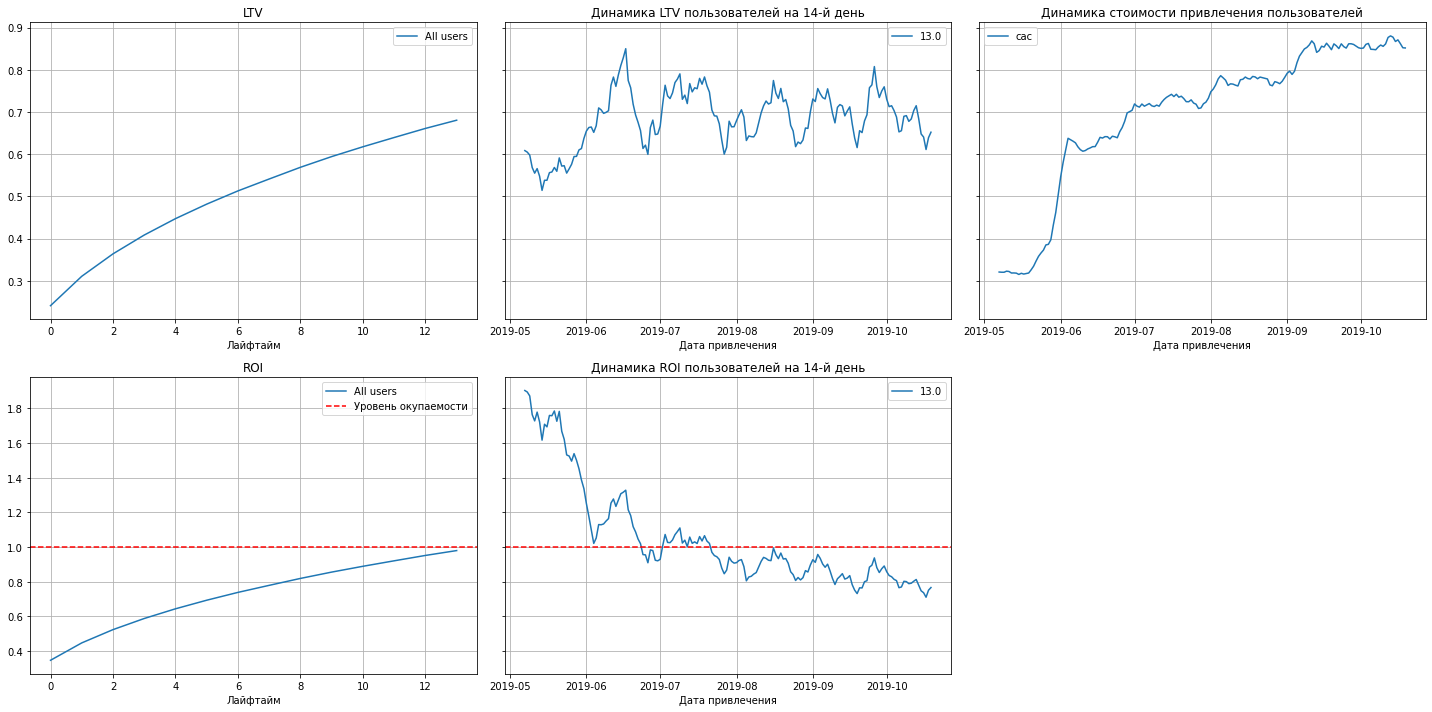

In [31]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

Попробуем также построить графики без учета органического прироста

In [32]:
profiles_n = profiles.query('channel != "organic"')

In [33]:
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
                                                                            profiles_n,
                                                                            orders,
                                                                            observation_date,
                                                                            horizon_days,
                                                                            dimensions=[],
                                                                            ignore_horizon=False,
                                                                        )

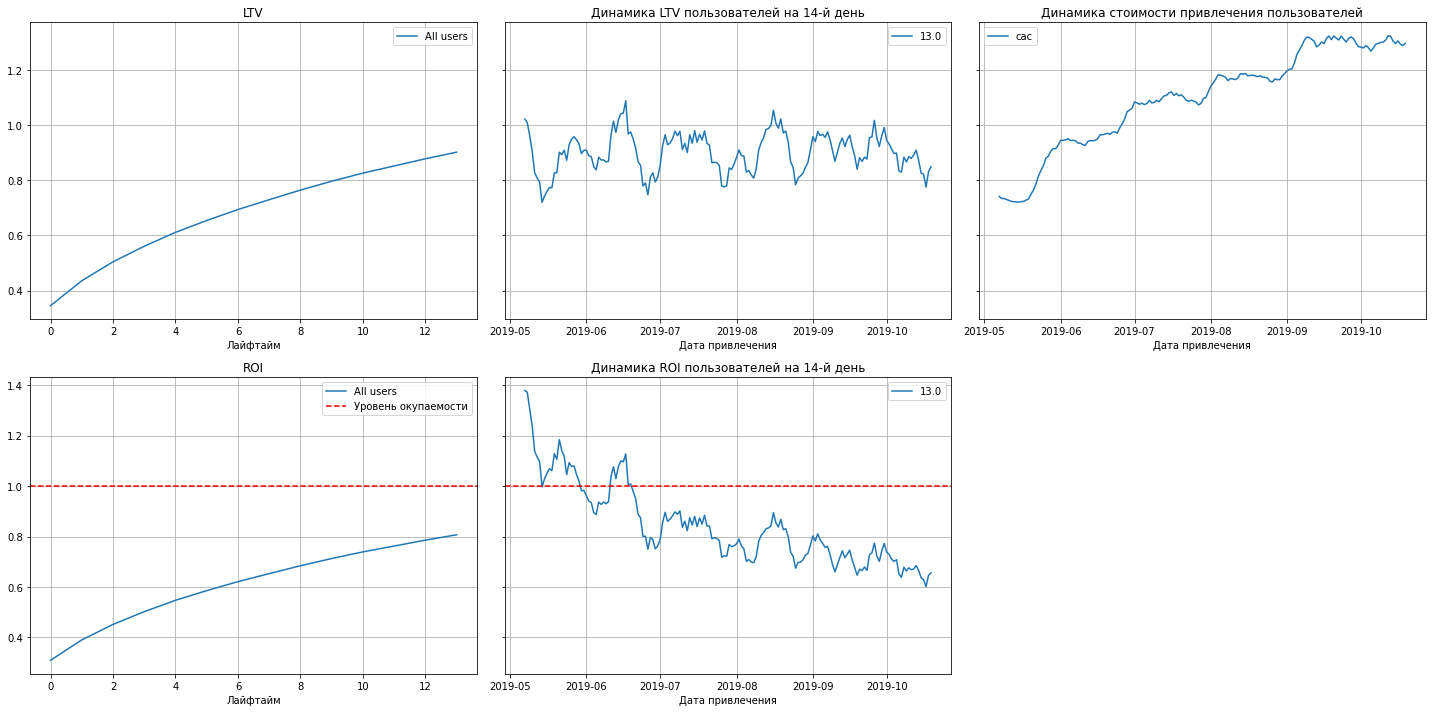

In [34]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

Можно сделать вывод:
* Совокупный ROI не может продолеть порог окупаемости, а в динамике его уровень даже падает
* При повышении динамики стоимости привлечения новых пользователей динамика 'пожизненной ценности' (LTV) клиентов так и остается в диапазоне от 0.8 до 1, вместо того, чтобы также расти.

### Конверсия и удержание

In [35]:
# Удержание 
result_raw, ret_grouped, ret_in_time = get_retention(
                                                    profiles_n,
                                                    visits,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[])

# Конверсия
result_raw, conv_grouped, conv_in_time = get_conversion(
                                                    profiles_n,
                                                    orders,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[])

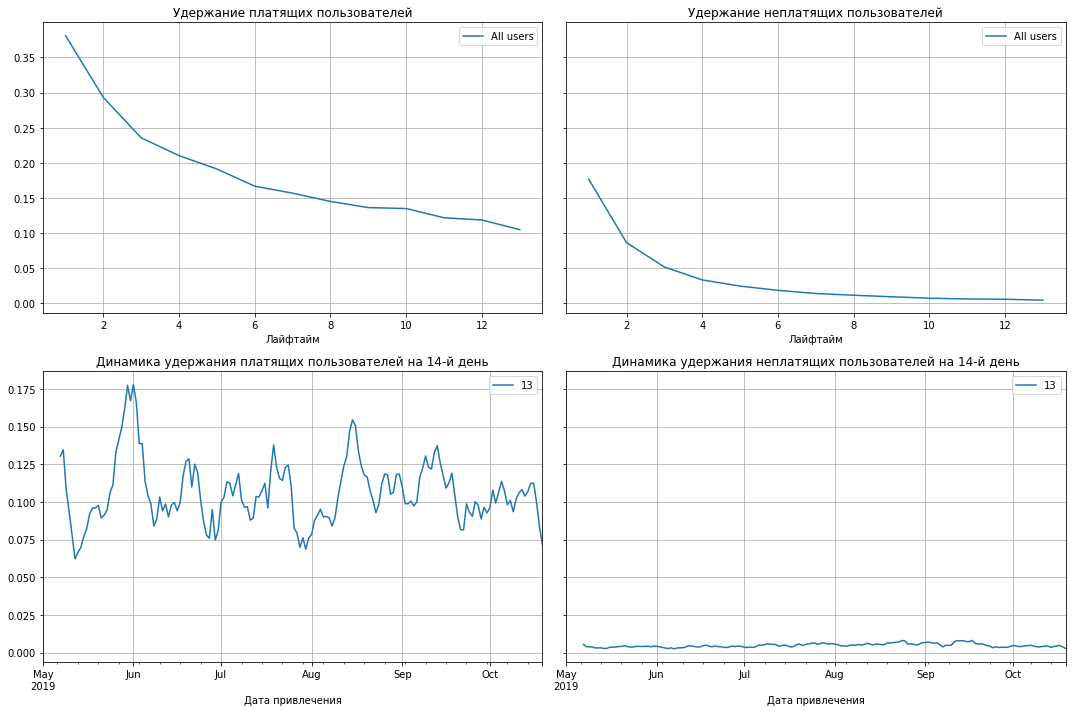

In [36]:
plot_retention(ret_grouped, ret_in_time, horizon_days)

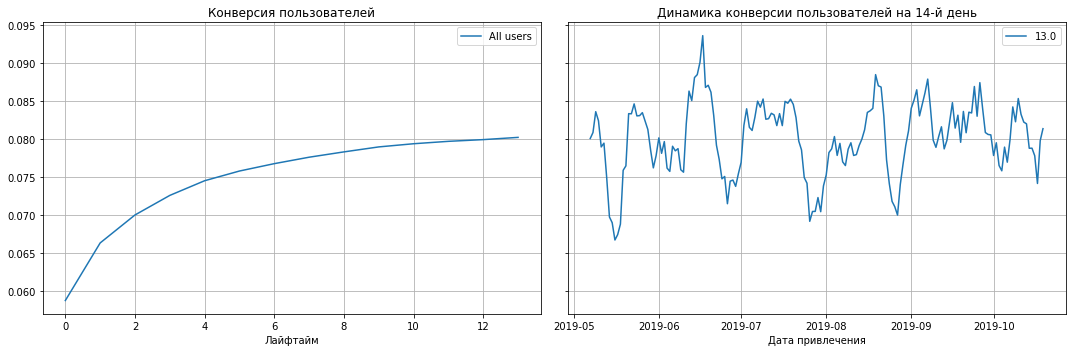

In [37]:
plot_conversion(conv_grouped, conv_in_time, horizon_days)

Удержание:  
* Удержание неплатящих пользователей снижается намного быстрее
* Динамика удержания стабильна, и не зависит от времени проведения рекламной компании

Конверсия:  
* Пик роста конверсии просиходит в первые 6 дней начала рекламы
* График динамики конверсии лежит в диапазоне примерно от 0.07 до 0.09

### LTV,ROI и CAC с разбивкой по устройствам 

In [38]:
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
                                                                            profiles_n,
                                                                            orders,
                                                                            observation_date,
                                                                            horizon_days,
                                                                            dimensions=['device'],
                                                                            ignore_horizon=False,
                                                                        )

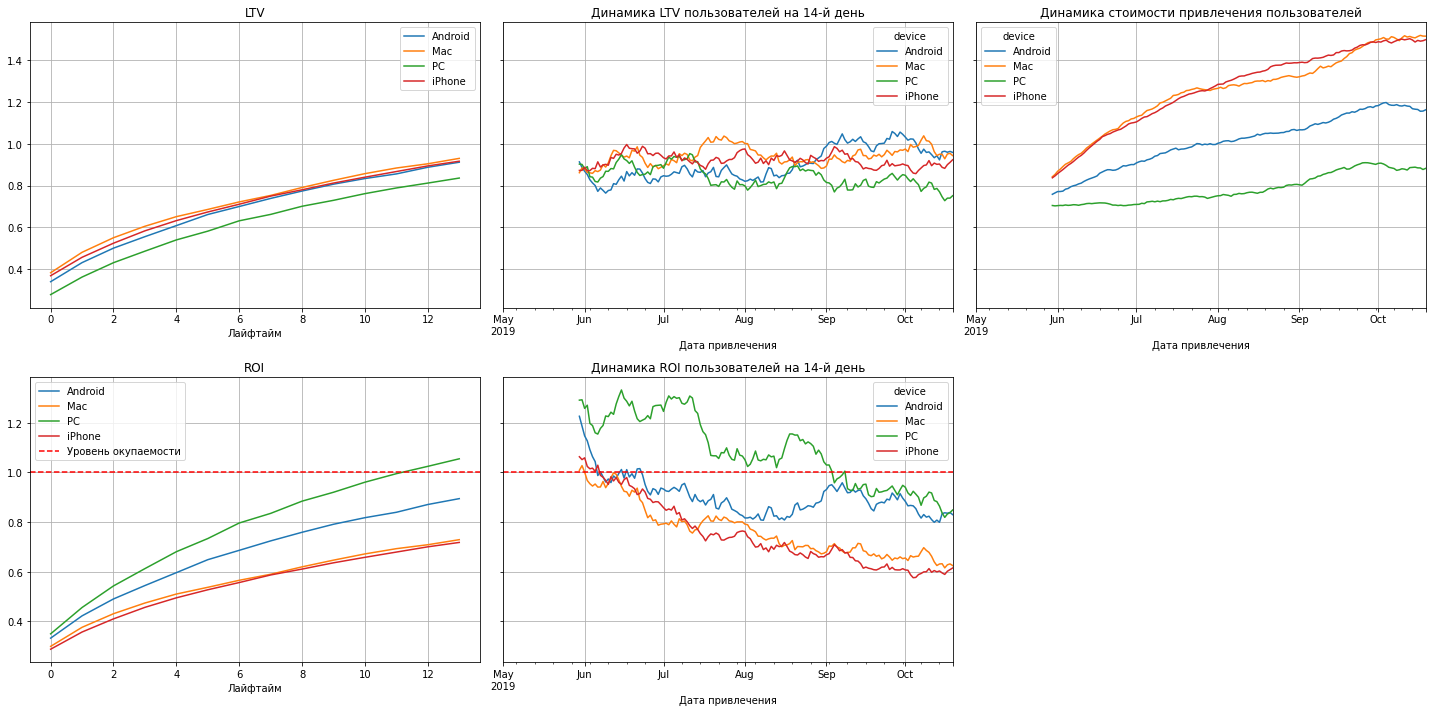

In [39]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days,window=30)

Делаем вывод, что реклама на девайсах компании Apple не окупается   
1. Рост динамики стоимости привлечения яблочных устройств намного интенсивней, чем у устройств под андройд и конечно ПК  
2. При этом динамика LTV для всех устройств лежит в одном же довольно узком диапазоне  
3. Динамика ROI показывает, что до начала сентября только реклама для ПК окупалась, после сентября все платформы стали убыточными


### LTV,ROI и CAC с разбивкой по странам

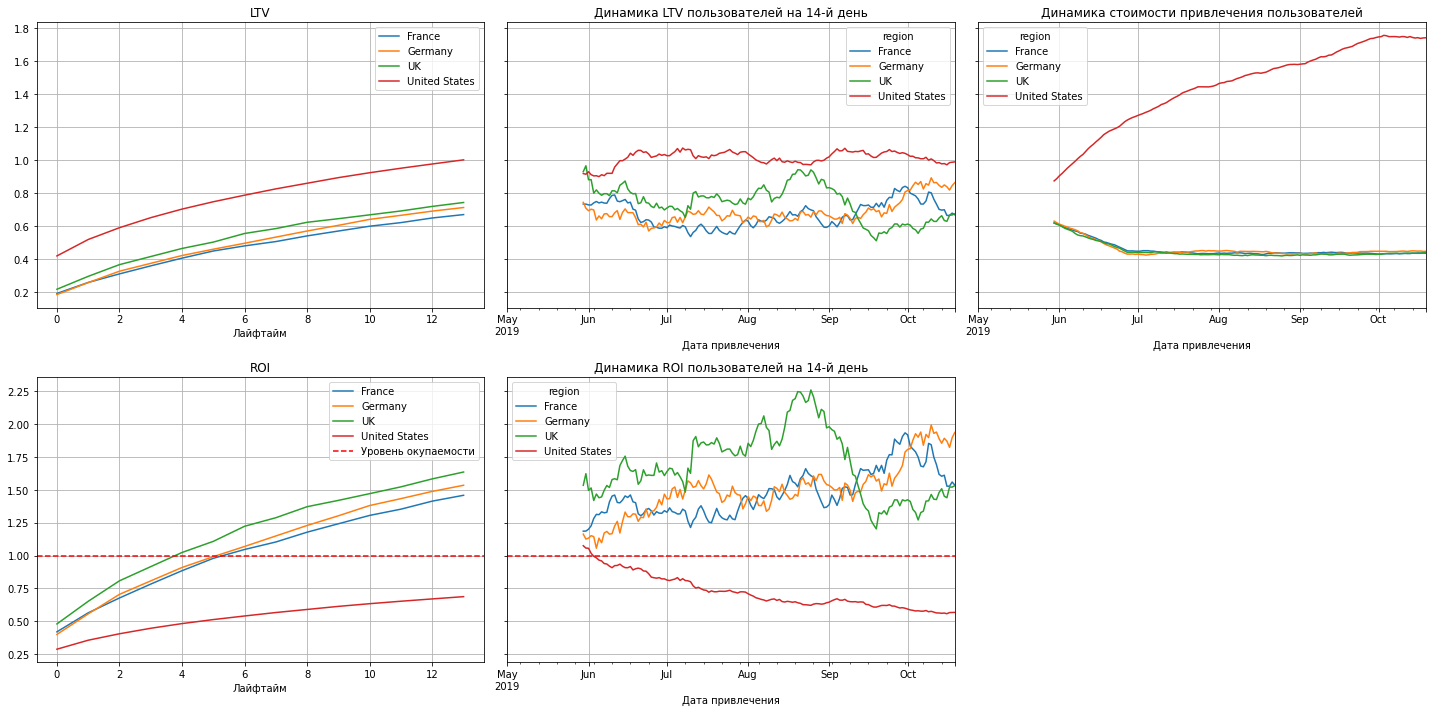

In [40]:
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
                                                                            profiles_n,
                                                                            orders,
                                                                            observation_date,
                                                                            horizon_days,
                                                                            dimensions=['region'],
                                                                            ignore_horizon=False,
                                                                        )

plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days,window=30)

Реклама в Штатах также не окупается  
1. В то время, как динамика стомости привлечения пользователя в европойских странах после 1 месяца и небольшого снижения вышла на некое плато, показатели США становились только больше с каждым месяцем, при этом динамика LTV у всех стран лежит в одном диапазоне  
2. Динамика ROI США показывает безостановочное снижение, в отличие от стран Европы

### LTV,ROI и CAC с разбивкой по источникам

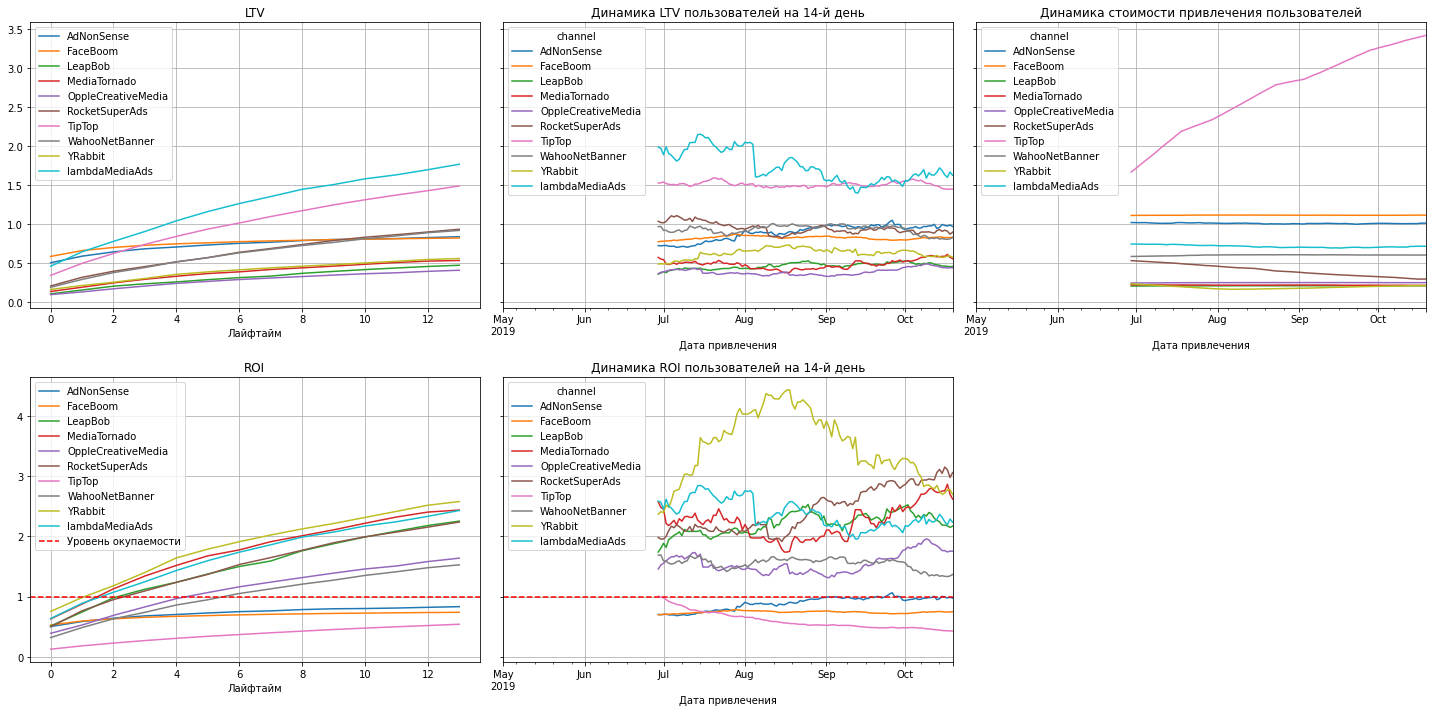

In [41]:
result_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
                                                                            profiles_n,
                                                                            orders,
                                                                            observation_date,
                                                                            horizon_days,
                                                                            dimensions=['channel'],
                                                                            ignore_horizon=False,
                                                                        )

plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days,window=60)

1. На графике динамики LTV выделяются 2 источника рекламы: lambdaMediaAds и TipTop. Динамика LTV остальных источников лежит в диапазоне чуть ниже.
2. График динамики САС выделяет резкий рост стомости привлечения в источнике TipTop
3. На графике ROI заметно, что TipTop, AdNonSence вместе с FaceBoom не могут окупить затраты на них 
4. График динамики ROI интересен доминирующими показателями источника YRabbit c июля по октябрь

### Конверсия и удержание по устройствам

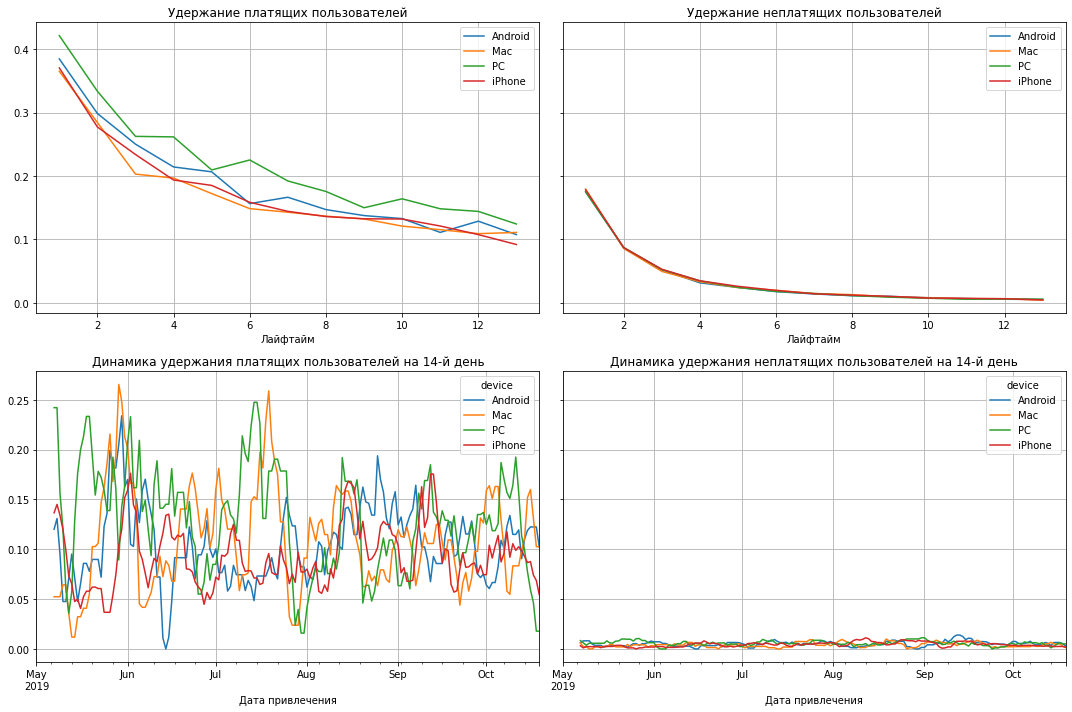

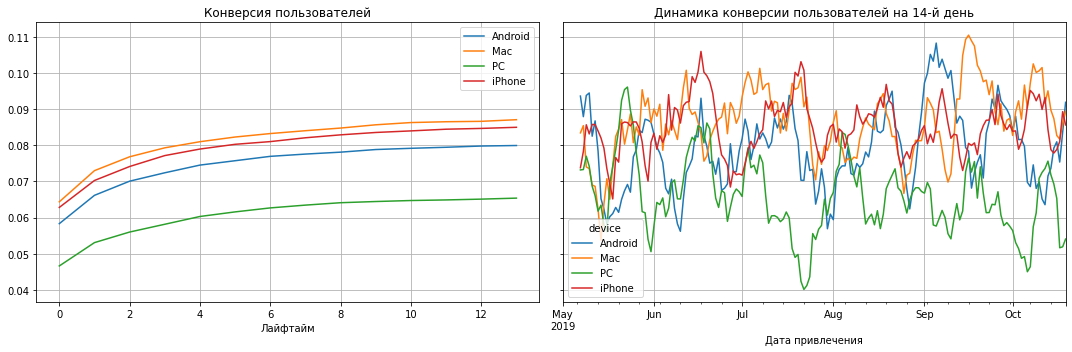

In [42]:
crt = 'device'
# Удержание 
result_raw, ret_grouped, ret_in_time = get_retention(
                                                    profiles_n,
                                                    visits,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

# Конверсия
result_raw, conv_grouped, conv_in_time = get_conversion(
                                                    profiles_n,
                                                    orders,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

plot_retention(ret_grouped, ret_in_time, horizon_days)
plot_conversion(conv_grouped, conv_in_time, horizon_days)

1. Удержание и динамика удержания неплатящих пользователей относительна динамики платяших крайне мала
2. В удержании платящих пользователей немного выигрывает ПК(разница между остальными платформами минимальна)
3. В конверсии пользователей лидерами являются девайсы Apple, чуть ниже - android, а на сильном удалении от них - ПК

### Конверсия и удержание по странам

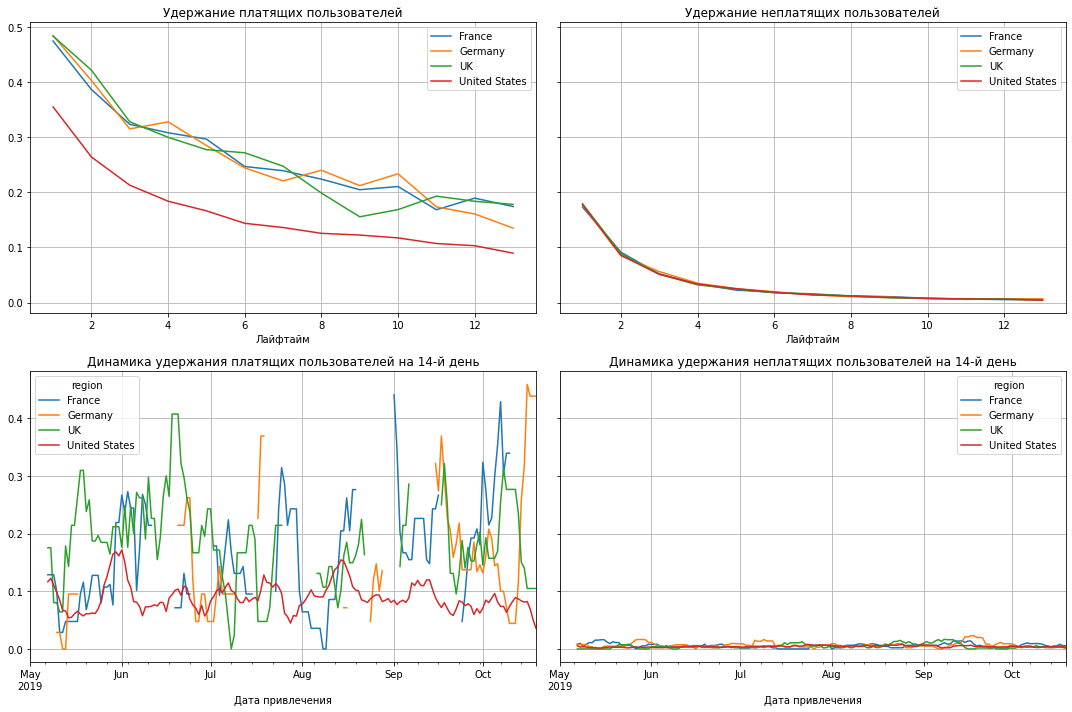

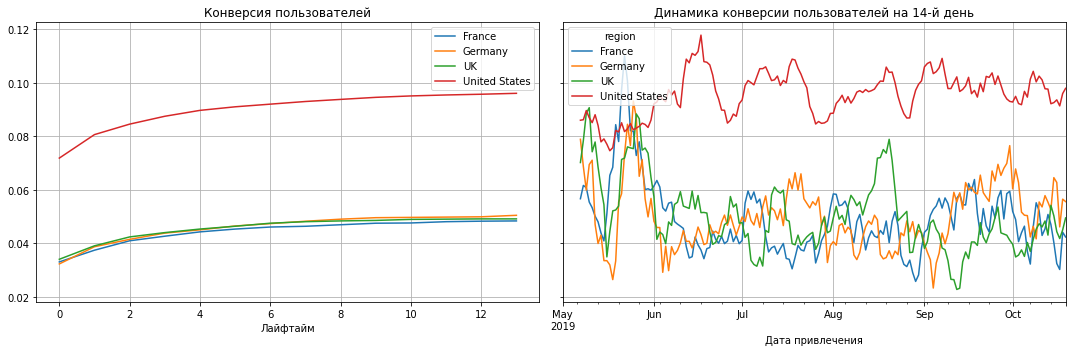

In [43]:
crt = 'region'
# Удержание 
result_raw, ret_grouped, ret_in_time = get_retention(
                                                    profiles_n,
                                                    visits,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

# Конверсия
result_raw, conv_grouped, conv_in_time = get_conversion(
                                                    profiles_n,
                                                    orders,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

plot_retention(ret_grouped, ret_in_time, horizon_days)
plot_conversion(conv_grouped, conv_in_time, horizon_days)

1. Удержание и динамика удержания неплатящих пользователей относительна динамики платяших крайне мала во всех странах
2. Удержание платящих пользователей хуже всего в Штатах, между Европейскими странами минимальные различия
3. А вот с конверсией дела обстоят наоборот - Штаты в лидерах с двукратным отрывом


### Конверсия и удержание по источникам

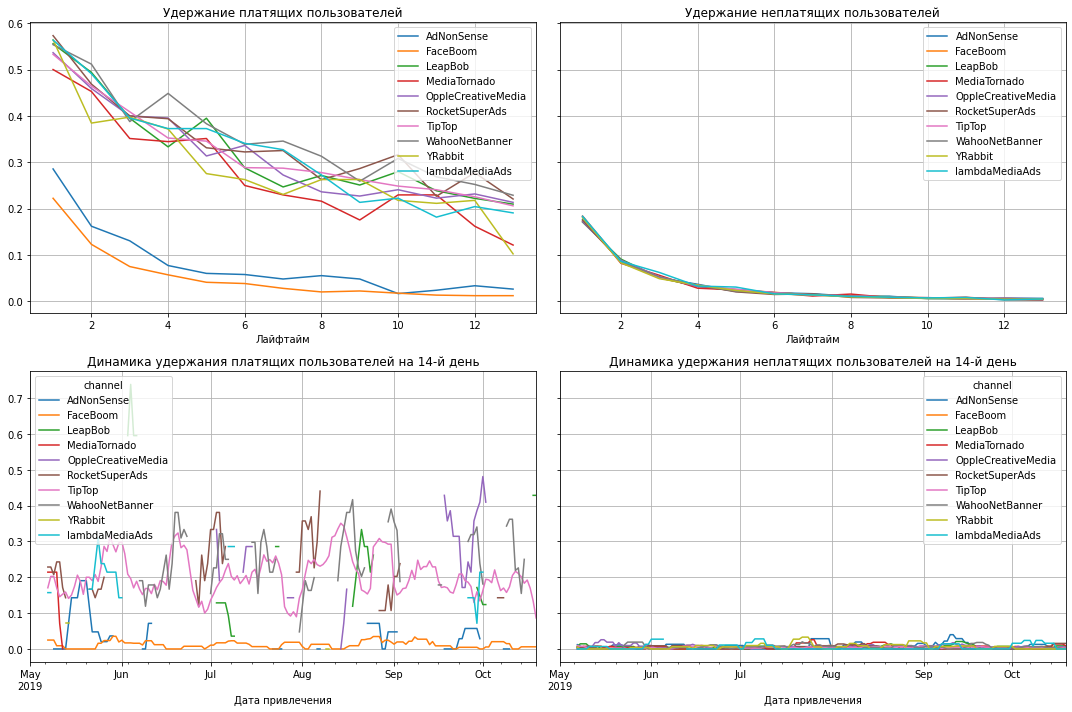

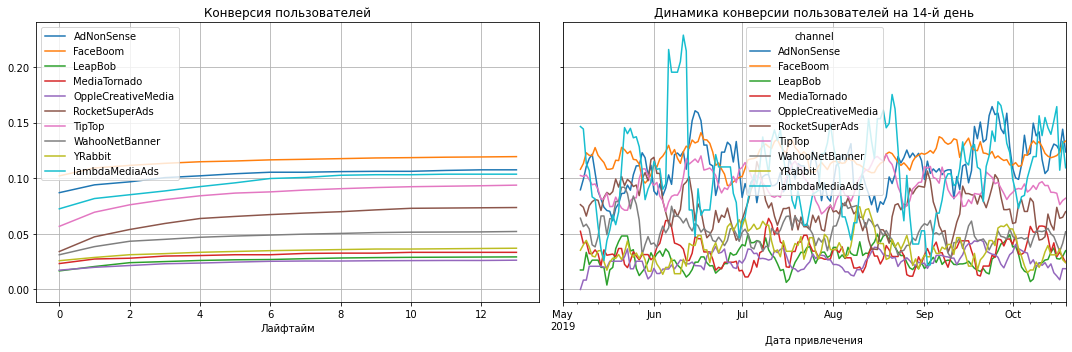

In [44]:
crt = 'channel'
# Удержание 
result_raw, ret_grouped, ret_in_time = get_retention(
                                                    profiles_n,
                                                    visits,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

# Конверсия
result_raw, conv_grouped, conv_in_time = get_conversion(
                                                    profiles_n,
                                                    orders,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

plot_retention(ret_grouped, ret_in_time, horizon_days)
plot_conversion(conv_grouped, conv_in_time, horizon_days)

1. Удержание и динамика удержания неплатящих пользователей относительна динамики платяших крайне мала во всех странах
2. Самое худшее удержание платящих пользователей показывают AdNonSence и FaceBoom. Остальные источники имеют минимально различимые между собой показатели.
3. lambdaMediaAds, AdNonSence и FaceBoom - лидеры по конверсии пользователей

### Конверсия и удержание по источникам в США

Для уточнения локальных рекламных источников рассмотрим отдельно рынки США и Европы

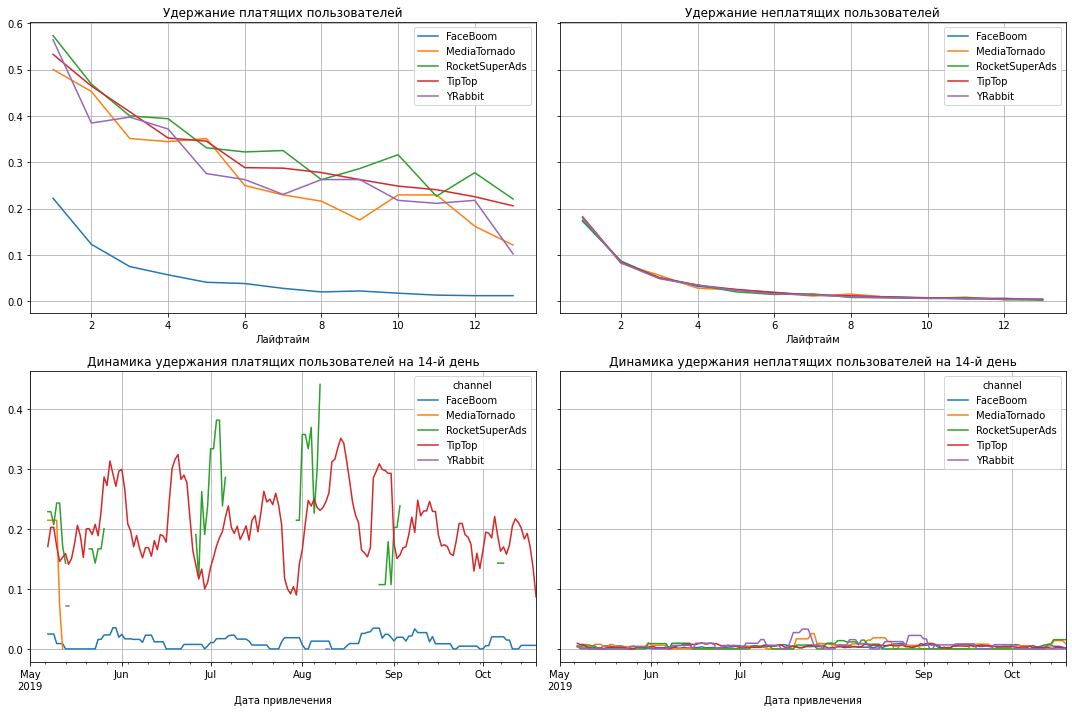

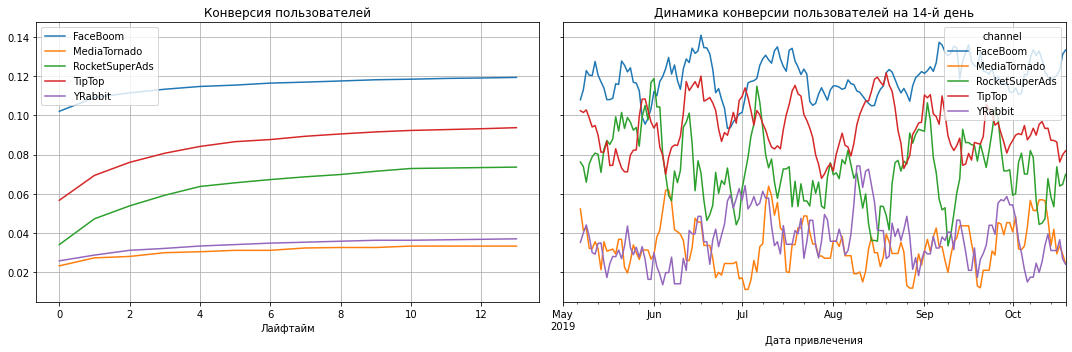

In [45]:
profiles_USA = profiles_n.query('region == "United States"')
crt = 'channel'
# Удержание 
result_raw, ret_grouped, ret_in_time = get_retention(
                                                    profiles_USA,
                                                    visits,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

# Конверсия
result_raw, conv_grouped, conv_in_time = get_conversion(
                                                    profiles_USA,
                                                    orders,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

plot_retention(ret_grouped, ret_in_time, horizon_days)
plot_conversion(conv_grouped, conv_in_time, horizon_days)

С учетом того, что FaceBoom и TipTop не окупаются, источником с хорошей конверсией и удержанием для американского рынка является __RocketSuperAds__

### Конверсия и удержание по источникам в Европе

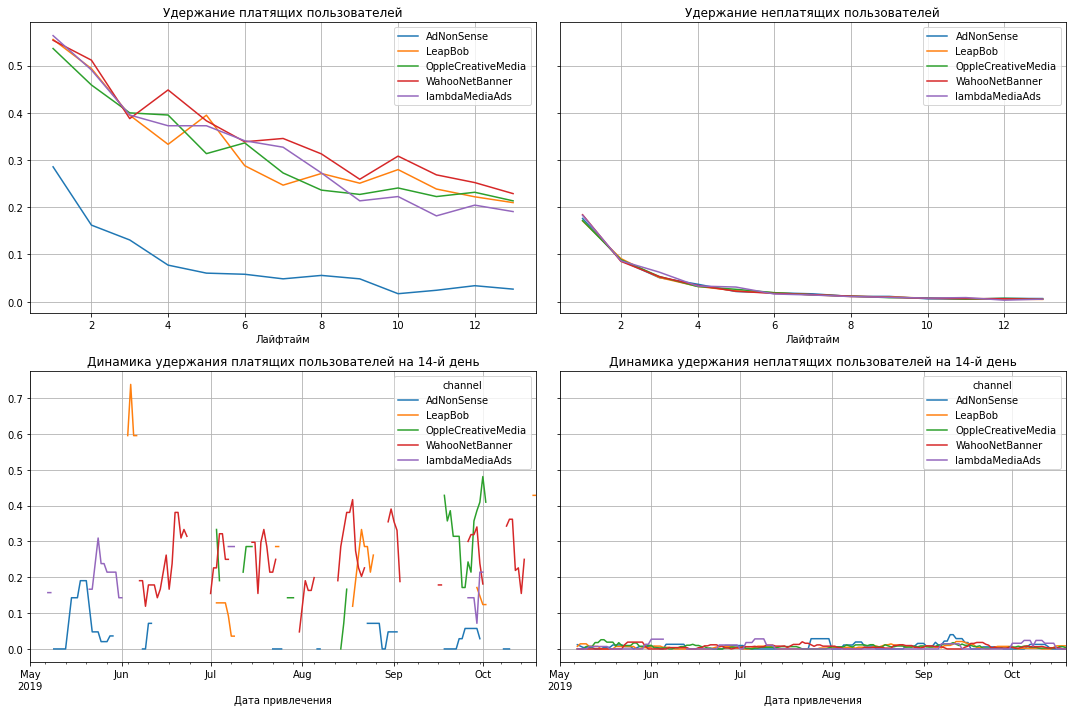

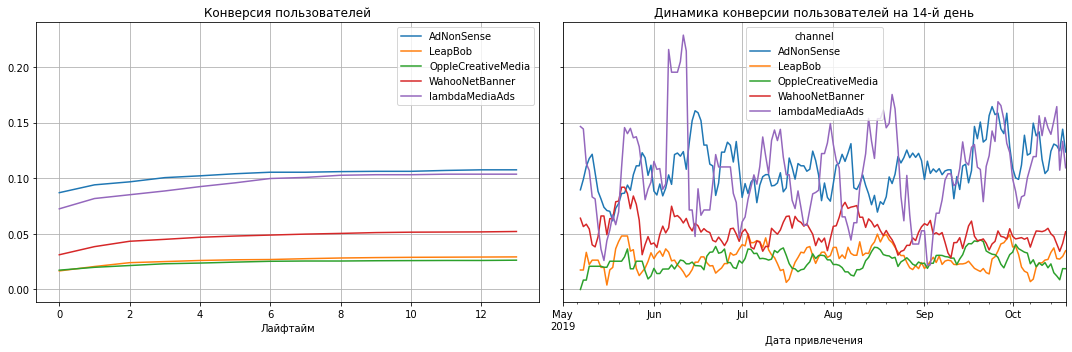

In [46]:
profiles_EU = profiles_n.query('region != "United States"')
crt = 'channel'
# Удержание 
result_raw, ret_grouped, ret_in_time = get_retention(
                                                    profiles_EU,
                                                    visits,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

# Конверсия
result_raw, conv_grouped, conv_in_time = get_conversion(
                                                    profiles_EU,
                                                    orders,
                                                    observation_date,
                                                    horizon_days,
                                                    dimensions=[crt])

plot_retention(ret_grouped, ret_in_time, horizon_days)
plot_conversion(conv_grouped, conv_in_time, horizon_days)

AdNonSence - антилидер по удержанию платящих пользователей.
Источником с высокой конверсией, удержанием и окупаемостью для европейского рынка является lambdaMediaAds

### Вывод по главе Оценка окупаемости рекламы

__Обшие выводы:__
* Совокупный ROI не может продолеть порог окупаемости, а в динамике его уровень даже падает
* Удержание неплатящих пользователей снижается намного быстрее
* Динамики удержания и конверсии стабильна, и не зависит от времени проведения рекламной компании

__По устройствам:__  
* В удержании платящих пользователей немного выигрывает ПК (разница между платформами минимальна)
* В конверсии пользователей лидерами являются девайсы Apple, чуть ниже - __android__, а на сильном удалении от них - ПК
* Рост динамики стоимости привлечения яблочных устройств намного интенсивней, чем у устройств под __android__ и конечно ПК  
* При этом динамика LTV для всех устройств лежит в одном же довольно узком диапазоне  
* Динамика ROI показывает, что до начала сентября только реклама для ПК окупалась, после сентября все платформы стали убыточными

__По странам:__  
* Удержание платящих пользователей хуже всего в Штатах, между Европейскими странами минимальные различия
* А вот с конверсией дела обстоят наоборот - Штаты в лидерах с двукратным отрывом
* В то время, как динамика стомости привлечения пользователя в европойских странах после 1 месяца и небольшого снижения вышла на некое плато, показатели США становились только больше с каждым месяцем, при этом динамика LTV у всех стран лежит в одном диапазоне  
* Динамика ROI США показывает безостановочное снижение, в отличие от стран Европы

__По источникам:__  
* Самое худшее удержание платящих пользователей показывают AdNonSence и FaceBoom. Остальные источники имеют минимально различимые между собой показатели.
* lambdaMediaAds, AdNonSence и FaceBoom - лидеры по конверсии пользователей
* На графике динамики LTV выделяются 2 источника рекламы: lambdaMediaAds и TipTop. Динамика LTV остальных источников лежит в диапазоне чуть ниже.
* График динамики САС выделяет резкий рост стомости привлечения в источнике TipTop
* На графике ROI заментно, что TipTop, AdNonSence вместе с FaceBoom не могут окупить затраты на них 
* График динамики ROI интересен доминирующими показателями источника YRabbit c июля по октябрь

    __Рынок США:__
* С учетом того, что FaceBoom и TipTop не окупаются, источником с хорошей конверсией и удержанием для американского рынка является __RocketSuperAds__  

    __Рынок Европы:__
* AdNonSence - антилидер по удержанию платящих пользователей. Источником с высокой конверсией, удержанием и окупаемостью для европейского рынка является lambdaMediaAds



## Выводы

В ходе данного проекта были решены следующие задачи:
1. Предобработка данных
2. Были прописанны функции профиля пользователя, удержания, конверсии, LTV, CAC, ROI
3. Исследователький анализ
4. Маркетинговый анализ
5. Оценка окупаемости рекламы


Итогом проекта стали выявленные причины неокупаемости рекламы и причины возможного решения

___Причины неэффективности привлечения пользователей:___  

__По странам:__  
В Соединеных Штатах проводится неэффективная рекламная компания
*  Удержание платящих пользователей отсительно рынка Европы намного хуже
* Динамика САС в странах Европы снижалась и выходила на плато, в то время как САС в штатах не прикращал свой ударный рост. В итоге ROI никогда не был выше порога окупаемости.

__По устройствам:__  
* Пользователи техники компании Apple хоть и имеют высокую конверсию, но не могут окупить себя
* Цены на их привлечение постоянно растут высокими темпами, как и для пользователей android

__По источникам:__  
* Большая часть рекламного бюджета была направлена на неокупаемые источники FaceBoom и TipTop
* FaceBoom имеет самые низкие показатели удержания платящих пользователей
* TipTop резко начал повышать стоимость привлечения (САС)
 ***

___Рекомендации___  
Вариант американского рынка:

 * Для того, чтобы сохранить американский рынок необходимо изменить как источник рекламы так и девайс
     * В качестве источника отличным кандидатом является __RocketSuperAds__, который имеет хорошие конверсию и удержание и окупается
     * Стоит присмотреться к такой платформе как __PC__ - САС практически не вырос за время рекламной компании
     
Альтернативный вариант - европейский рынок:
 * Необходимо назначить источником на европейском рынке __lambdaMediaAds__
     * Он имеет высокие удержание и конверсию, а также окупается
 ;